In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from data_preprocessing import preprocess

df1 = preprocess()

In [2]:
mapping = {
    "Ch1": "F7", "Ch2": "F3", "Ch3": "F4", "Ch4": "F8",
    "Ch5": "T3", "Ch6": "C3", "Ch7": "Cz", "Ch8": "C4",
    "Ch9": "T4", "Ch10": "T5", "Ch11": "P3", "Ch12": "Pz",
    "Ch13": "P4", "Ch14": "T6", "Ch15": "O1", "Ch16": "O2"}


In [3]:
def correlation_matrix(patient_id, wave_option='power_beta'):
    # Filter data for the selected patient
    patient_data = df1[df1['id'] == patient_id]

    # Get the unique region names
    regions = patient_data['region'].unique()

    # Create an empty list to hold the power data for each region (channel)
    power_data = []

    # Loop through the regions (channels) and extract power data
    for region in regions:
        # Filter power data for the current region
        region_data = patient_data[patient_data['region'] == region]
        
        # Append the power data (list) for this region to the list
        power_data.append(region_data[wave_option].values[0])  # Assuming 'power' is a list

    # Convert the list of power data (regions x time points) into a DataFrame
    power_df = pd.DataFrame(power_data, index=regions).transpose()  # Regions as row labels

    # Check for NaN values and fill or drop them
    if power_df.isnull().values.any():
        print(f"Warning: Missing values detected in power data for patient {patient_id}")
        power_df = power_df.fillna(0)  # Fill NaN with 0 (you can change this to another method)

    # Calculate the correlation matrix for the 16 regions (channels)
    corr_matrix = power_df.corr(method='pearson')  # Pearson correlation

    return corr_matrix, regions


In [4]:
def average_correlation(patient_ids, wave_option='power_beta'):
    correlation_sums = None
    count = 0

    # Loop through each patient and calculate their correlation matrix
    for patient_id in patient_ids:
        corr_matrix, regions = correlation_matrix(patient_id, wave_option)
        
        # Add the current correlation matrix to the cumulative sum
        if correlation_sums is None:
            correlation_sums = corr_matrix
        else:
            correlation_sums += corr_matrix
        
        count += 1

    # Calculate the average correlation matrix
    average_corr_matrix = correlation_sums / count
    return average_corr_matrix, regions

In [5]:
healthy_patients = df1[df1['schizo'] == 0]['id'].unique().tolist()
schizo_patients = df1[df1['schizo'] == 1]['id'].unique().tolist()


#BETA

In [6]:
def plot_correlation_matrices(healthy_patients, schizo_patients, wave_option='power_beta', difference_only=True):
    # Calculate average correlation matrices for both healthy and schizophrenic patients
    avg_corr_healthy, regions = average_correlation(healthy_patients, wave_option=wave_option)
    avg_corr_schizo, _ = average_correlation(schizo_patients, wave_option=wave_option)
    corr_difference = avg_corr_healthy - avg_corr_schizo

    # Get the regions (they should be consistent across all patients)
    regions = avg_corr_healthy.columns.tolist()  # Get region names from the columns of the correlation matrix
    if difference_only == False:
        # Plot for healthy patients
        plt.figure(figsize=(10, 8))
        sns.heatmap(avg_corr_healthy, annot=True, cmap='coolwarm', fmt='.2f', xticklabels=regions, yticklabels=regions)
        plt.title(f"Average Correlation Matrix for Healthy Patients ({wave_option.capitalize()})")
        plt.xlabel('Regions (Channels)')
        plt.ylabel('Regions (Channels)')
        plt.show()

        # Plot for schizophrenic patients
        plt.figure(figsize=(10, 8))
        sns.heatmap(avg_corr_schizo, annot=True, cmap='coolwarm', fmt='.2f', xticklabels=regions, yticklabels=regions)
        plt.title(f"Average Correlation Matrix for Schizophrenic Patients ({wave_option.capitalize()})")
        plt.xlabel('Regions (Channels)')
        plt.ylabel('Regions (Channels)')
        plt.show()

    # Plot the correlation difference (healthy - schizo)
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_difference, annot=True, cmap='coolwarm', fmt='.2f', xticklabels=regions, yticklabels=regions)
    plt.title('Correlation Difference (Healthy - Schizophrenic)')
    plt.xlabel('Regions (Channels)')
    plt.ylabel('Regions (Channels)')
    plt.show()
    
    return avg_corr_healthy, avg_corr_schizo, corr_difference

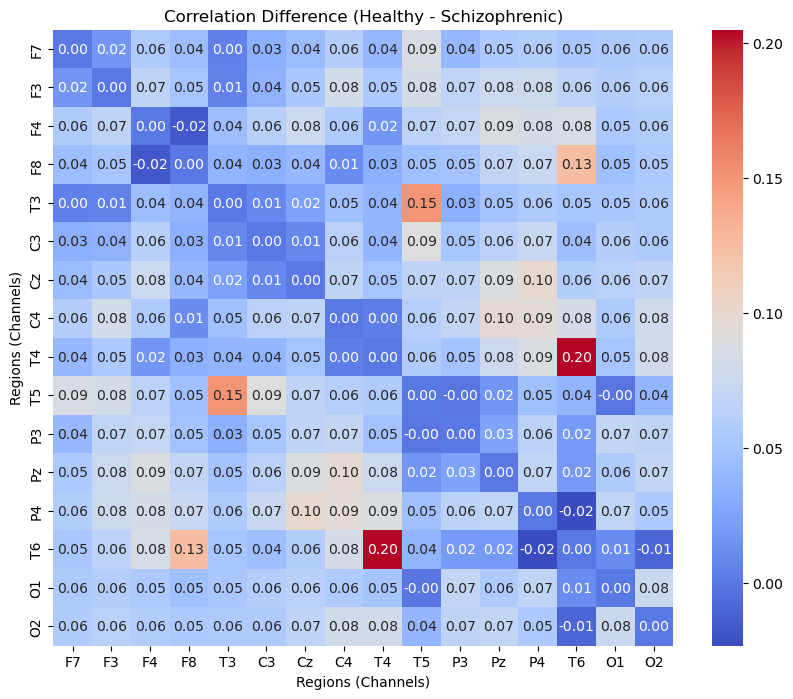

In [7]:
beta_healthy, beta_schizo, beta_dif = plot_correlation_matrices(healthy_patients, schizo_patients, wave_option='power_beta', difference_only=True)

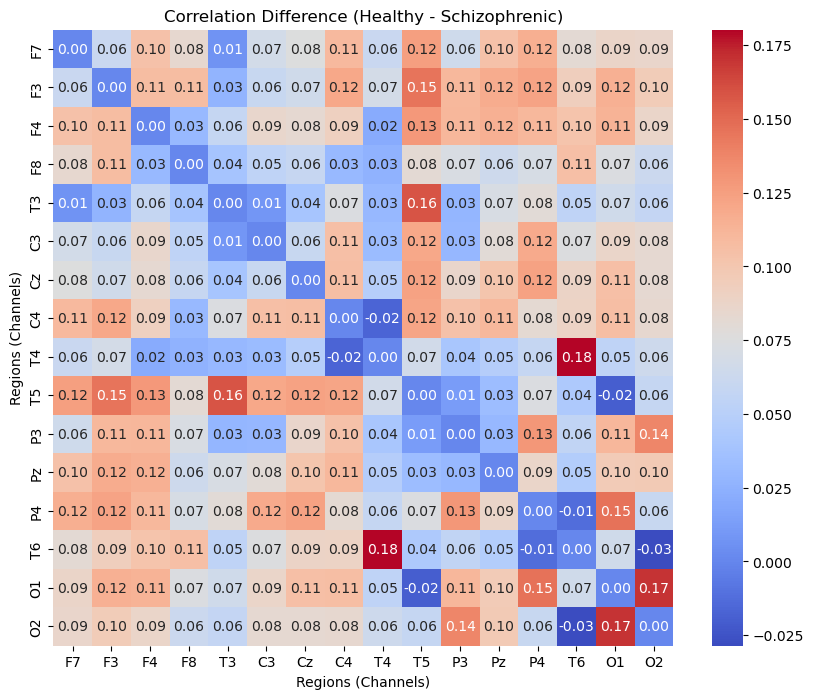

In [18]:
alpha_healthy, alpha_schizo, alpha_dif = plot_correlation_matrices(healthy_patients, schizo_patients, wave_option='power_alpha')

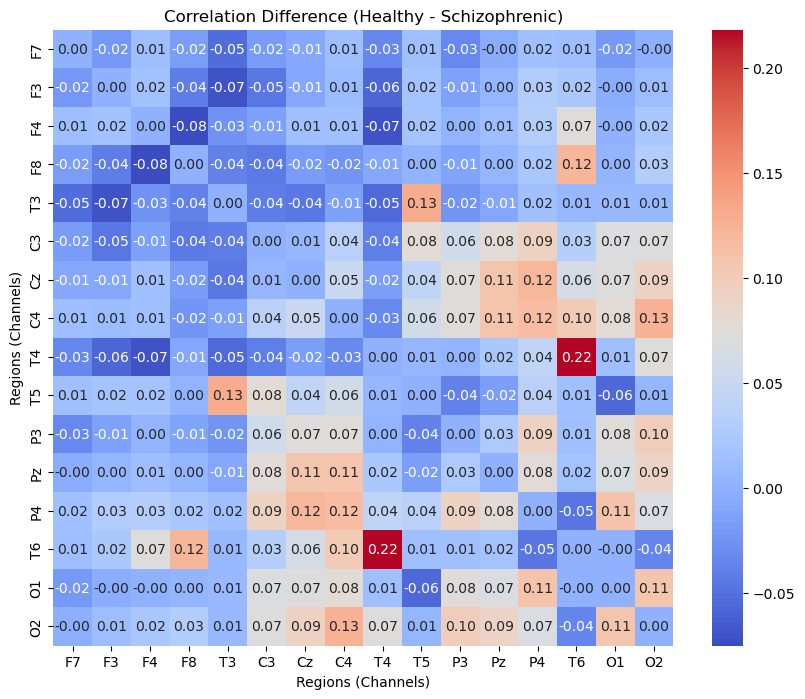

In [19]:
theta_healthy, theta_schizo, theta_dif = plot_correlation_matrices(healthy_patients, schizo_patients, wave_option='power_theta')

In [10]:
cross_correlation_matrix = np.array(beta_healthy)

channel_names = [
        "F7", "F3", "F4", "F8",
        "T3", "C3", "Cz", "C4",
        "T4", "T5", "P3", "Pz",
        "P4", "T6", "O1", "O2"
    ]


    # Average the correlation for each channel
channel_correlations = cross_correlation_matrix.mean(axis=1)

    # Ensure the data is a 2D array with shape (n_channels, 1)
channel_correlations = channel_correlations.reshape(-1, 1)

    # Define montage (standard 10-20 system for EEG)
montage = mne.channels.make_standard_montage('standard_1020')

    # Create an MNE Info object
info = mne.create_info(
        ch_names=channel_names,
        sfreq=128,  # Sampling frequency (adjust if needed)
        ch_types="eeg"
    )

    # Create an Evoked object to hold the data for plotting
evoked = mne.EvokedArray(data=channel_correlations, info=info)
evoked.set_montage(montage)


<Evoked | '' (average, N=1), 0 – 0 s, baseline off, 16 ch, ~24 kB>

In [13]:
evoked.data

array([[0.49712706],
       [0.52884983],
       [0.5260974 ],
       [0.49057736],
       [0.52012964],
       [0.59065584],
       [0.60594727],
       [0.60457035],
       [0.52657793],
       [0.50327545],
       [0.58186615],
       [0.6020769 ],
       [0.58514026],
       [0.50301017],
       [0.49477324],
       [0.50201316]])

In [15]:
import mne
import numpy as np

def topographical_map(cross_correlation_matrix):
    # Ensure data is a 2D numpy array
    cross_correlation_matrix = np.array(cross_correlation_matrix)

    # EEG channel names corresponding to your heatmap (10-20 system)
    channel_names = [
        "F7", "F3", "F4", "F8",
        "T3", "C3", "Cz", "C4",
        "T4", "T5", "P3", "Pz",
        "P4", "T6", "O1", "O2"
    ]

    # Average the correlation for each channel
    channel_correlations = cross_correlation_matrix.mean(axis=1)

    # Ensure the data is a 2D array with shape (n_channels, 1)
    channel_correlations = channel_correlations.reshape(-1, 1)

    # Define montage (standard 10-20 system for EEG)
    montage = mne.channels.make_standard_montage('standard_1020')

    # Create an MNE Info object
    info = mne.create_info(
        ch_names=channel_names,
        sfreq=128,  # Sampling frequency (adjust if needed)
        ch_types="eeg"
    )

    # Create an Evoked object to hold the data for plotting
    evoked = mne.EvokedArray(data=channel_correlations, info=info)
    evoked.set_montage(montage)

    # Plot the topomap
    times = [0]  # Since this is static data, we use a single time point
    evoked.plot_topomap(
        times=times,
        ch_type='eeg',
        show=True,
        size=3,  # Set appropriate size for visibility
        vlim=(250000, 700000),
        units='Correlation',
        colorbar=True  # Ensure the color bar is shown for reference
    )

    # Display the plot
    plt.show()

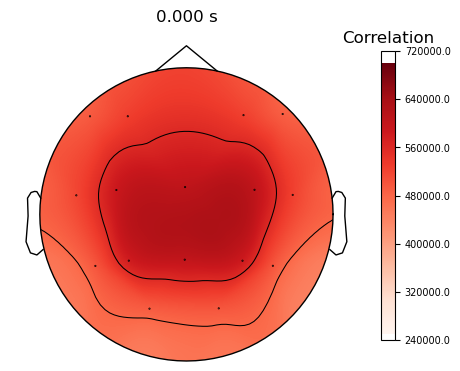

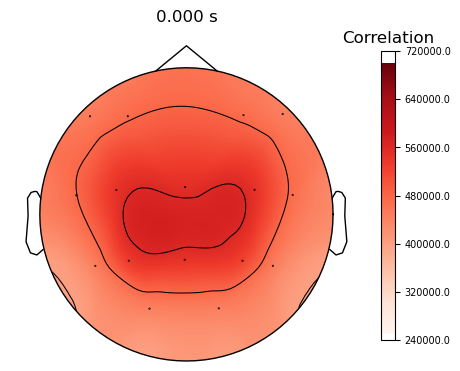

In [16]:
topographical_map(beta_healthy)
topographical_map(beta_schizo)

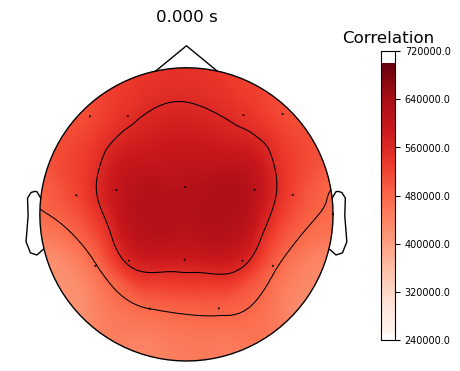

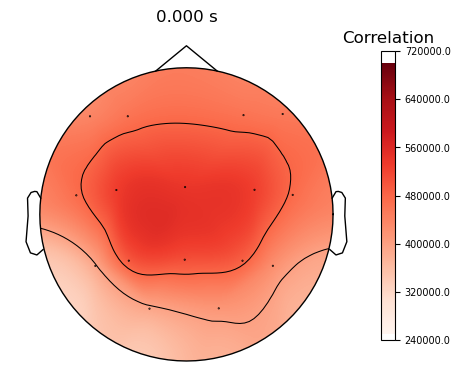

In [21]:
topographical_map(alpha_healthy)
topographical_map(alpha_schizo)

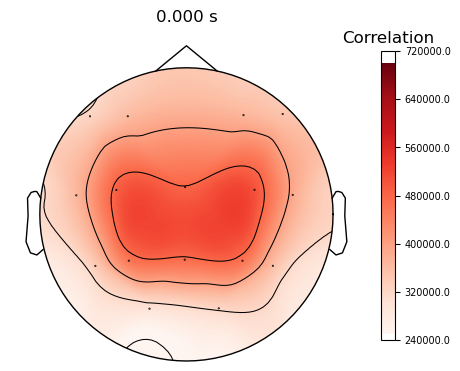

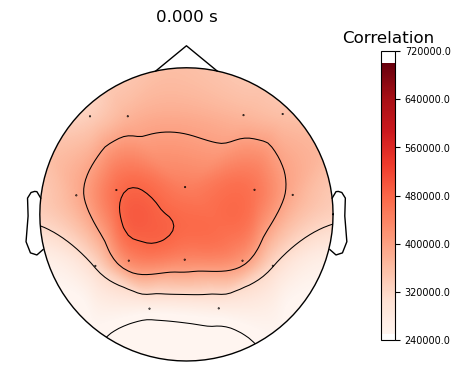

In [20]:
topographical_map(theta_healthy)
topographical_map(theta_schizo)